## Table of Contents:

1. [Problem Definition](#1.-Problem-Definition)
2. [Understanding the Data and the Challenges](#2.-Understanding-the-Data-and-the-Data-Challenges)
    * [2.a CelebA Dataset](#2.a-CelebA-Dataset)
    * [2.b The Challenges in Getting the Data](#2.b-The-Challenges-in-Getting-the-Data)
3. [Modeling](#3.-Modeling)
    * [3.1 Importing Data](#3.1-Importing-Data)
    * [3.2 Reshaping Data](#3.2-Reshaping-Data)
    * [3.3 3.3 Trying and Exploring Different Models](#3.3-Trying-and-Exploring-Different-Models)
        * [3.3.1 Starting with SegNet: A Convolutional Encoder-Decoder Network](#3.3.1-Starting-with-SegNet:-A-Convolutional-Encoder-Decoder-Network)
            * [3.3.1.1 Building the Model](#3.3.1.1-Building-the-Model)
            * [3.3.1.2 Compiling the Model](#3.3.1.2-Compiling-the-Model)
            * [3.3.1.3 Importing and Augmenting the Data](#3.3.1.3-Importing-and-Augmenting-the-Data)
            * [3.3.1.4 Training the Model](#3.3.1.4-Training-the-Model)
            * [3.3.1.4 Visualizing the Predictions](#3.3.1.5-Visualizing-the-Predictions)
        * [3.3.2 Implementation of Deep Image Matting Model](#3.3.3-Implementation-of-Deep-Image-Matting-Model)
            * [3.3.2.1 Idea](#3.3.2.1-Idea)
            * [3.3.2.2 Implementation](#3.3.2.2-Implementation)
            * [3.3.2.3 Understanding the Loss Functions](#3.3.2.3-Understanding-the-Loss-Functions)
            * [3.3.2.4 Visualizing the results](#3.3.2.4-Visualizing-the-results)
    * [3.4 Evaluating the Models](#3.4-Evaluating-the-Models)
4. [Conclusion](#4.-Conclusion)

## 1. Problem Definition
__Image matting__ is the process of extracting the foreground from an image.  
The objective of this work is to extract human portraits from images.  
There is a difficulty in keeping some details in a photo like flying hairs. There is a solution called [Deep Image Matting](https://arxiv.org/abs/1703.03872) to tackle this problem.  

How can image matting be used? Here are some applications which may need image matting:

* Tools the end-users enjoy (i.e., Making the background of a photo blurry, imitating the quality of a large-aperture lens)
* Applying a different background in image and video production

## 2. Understanding the Data and the Data Challenges

### 2.a CelebA Dataset

For this work, the dataset in consideration is [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which contains more than 200K celebrity images. However, it is not image-mask pair but image-landmarks tagging. Therefore, it is not perfectly suitable for this problem.

### 2.b The Challenges in Getting the Data

I will select and process some images to create masks.  

  
* Step 1: I calculated the time I spent in removing the background in Photoshop. I found that I can process 200 images in 6 hours.  
* Step 2: I randomly selected 200 images and processed them. Here is one example:

![Matting-Photoshop](images/matting-image-photoshop.png)

**Step 3:** I added random backgrounds to matted images for getting more image-mask pairs.  

In the end, I have nearly 800 image-mask pairs as training data.  

# 3. Modeling
In this part, I will start with SegNet, which is a robust convolutional encoder-decoder network for pixel-wise segmentation.  
Then, I will try the Deep Image Matting idea.  

In [107]:
# system
import os

# image, matrix processing
import numpy as np
from PIL import Image

# plotting
import matplotlib.pyplot as plt

# img preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# deep learning
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Input, Lambda, Concatenate, BatchNormalization, ZeroPadding2D, Reshape, Layer, Multiply, Activation
from tensorflow.keras.layers import Max

# models
from tensorflow.keras.models import Model
from tensorflow.keras import Model

from tensorflow.keras import backend as K

Allowing GPU:

In [2]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.test.is_gpu_available()

True

## 3.3 Trying and Exploring Different Models
### 3.3.1 Starting with SegNet: A Convolutional Encoder-Decoder Network

It is important to understand this model architecture because deep image matting will be on top of this network.  

![Segnet](https://mi.eng.cam.ac.uk/projects/segnet/images/segnet.png)

Understanding Encoder-Decoder networks: 
- The __encoder__ encodes image data and stores it in the latent space.  
- The __decoder__ reconstructs an image by taking the latent space as input.  

#### 3.3.1.1 Building the Model

For computational efficiency, I resized the images into 256x256 pixels.  

In [3]:
img_dim_pixel = 256
kernel = 3

SegNet model definition is taken from this repo: https://github.com/foamliu/Deep-Image-Matting/blob/master/segnet.py 

In [4]:
class Unpooling(Layer):

    def __init__(self, **kwargs):
        super(Unpooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Unpooling, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs[:, 1]
        bool_mask = Lambda(lambda t: K.greater_equal(t[:, 0], t[:, 1]),
                           output_shape=K.int_shape(x)[1:])(inputs)
        mask = Lambda(lambda t: K.cast(t, dtype='float32'))(bool_mask)
        x = Multiply()([mask, x])
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2], input_shape[3], input_shape[4]

In [5]:
# Encoder
input_tensor = Input(shape=(img_dim_pixel, img_dim_pixel, 3))

x = ZeroPadding2D((1, 1))(input_tensor)
x = Conv2D(64, (kernel, kernel), activation='relu', name='conv1_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(64, (kernel, kernel), activation='relu', name='conv1_2')(x)
orig_1 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(128, (kernel, kernel), activation='relu', name='conv2_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(128, (kernel, kernel), activation='relu', name='conv2_2')(x)
orig_2 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(256, (kernel, kernel), activation='relu', name='conv3_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(256, (kernel, kernel), activation='relu', name='conv3_2')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(256, (kernel, kernel), activation='relu', name='conv3_3')(x)
orig_3 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv4_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv4_2')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv4_3')(x)
orig_4 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv5_1')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv5_2')(x)
x = ZeroPadding2D((1, 1))(x)
x = Conv2D(512, (kernel, kernel), activation='relu', name='conv5_3')(x)
orig_5 = x
x = MaxPooling2D((2, 2), strides=(2, 2))(x)

# Decoder
#
x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_5)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_5)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='deconv5_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='deconv5_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (kernel, kernel), activation='relu', padding='same', name='deconv5_3',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_4)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_4)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='deconv4_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='deconv4_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (kernel, kernel), activation='relu', padding='same', name='deconv4_3',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_3)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_3)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='deconv3_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='deconv3_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (kernel, kernel), activation='relu', padding='same', name='deconv3_3',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_2)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_2)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv2_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv2_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = UpSampling2D(size=(2, 2))(x)
the_shape = K.int_shape(orig_1)
shape = (1, the_shape[1], the_shape[2], the_shape[3])
origReshaped = Reshape(shape)(orig_1)
xReshaped = Reshape(shape)(x)
together = Concatenate(axis=1)([origReshaped, xReshaped])
x = Unpooling()(together)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv1_1',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (kernel, kernel), activation='relu', padding='same', name='deconv1_2',
           kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)

x = Conv2D(1, (kernel, kernel), activation='sigmoid', padding='same', name='pred', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)

segnet = Model(inputs=input_tensor, outputs=x)

#### 3.3.1.2 Compiling the Model

In [7]:
# compiling the model
segnet.compile(optimizer='adam',
               loss='binary_crossentropy'
              )

#### 3.3.1.3 Importing and Augmenting the Data

The data are structured on the disk as follows:

    data
    ├── test
    │   ├── images/files
    │   │   ├── 150496.png
    │   │   ├── 057190.png
    │   │   ├── ...
    │   │   └── ...
    │   └── masks/files
    │       ├── 076091.png
    │       ├── 083990.png
    │       ├── ...  
    │       └── ...
    ├── train
    │   ├── images/files
    │   │   ├── 127444.png
    │   │   ├── 058770.png
    │   │   ├── ...
    │   │   └── ...
    │   └── masks/files
    │       ├── 055621.png
    │       ├── 068465.png
    │       ├── ...
    │       └── ...
    └── val
        ├── images/files
        │   ├── 065456.png
        │   ├── 085476.png
        │   ├── ...        
        │   └── ...
        └── masks/files
            ├── 078963.png
            ├── 124666.png
            ├── ...            
            └── ...
            
The following code chunks are importing images and storing them in `numpy` arrays.  

In [8]:
data_dir = '/media/imran/SSD/celeba/data'
train_images = os.path.join(data_dir, 'train/images')
train_masks = os.path.join(data_dir, 'train/masks')
test_images = os.path.join(data_dir, 'test/images')

**Data Augmentation**
To prevent overfitting, we can do augmentations like horizontal flip and zoom.  

In [9]:
data_gen_args = dict(
    horizontal_flip = True,
    rescale=1./255
)

seed=1
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# train
image_train_generator = image_datagen.flow_from_directory(
    train_images,
    class_mode=None,
    batch_size=16,
    target_size = (img_dim_pixel, img_dim_pixel),
    seed=seed)
mask_train_generator = mask_datagen.flow_from_directory(
    train_masks,
    class_mode=None,
    #color_mode = 'grayscale',
    batch_size = 16,
    target_size = (img_dim_pixel, img_dim_pixel),
    seed=seed)

train_generator = (pair for pair in zip(image_train_generator, mask_train_generator))

# test
image_test_generator = image_datagen.flow_from_directory(
    test_images,
    class_mode=None,
    target_size = (img_dim_pixel, img_dim_pixel),
    seed=seed)

Found 351 images belonging to 1 classes.
Found 351 images belonging to 1 classes.
Found 39 images belonging to 1 classes.


#### 3.3.1.4 Training the Model

In [10]:
model_name = 'segnet'+str(img_dim_pixel)+'.h5'

In [16]:
segnet.load_weights(model_name)

In [ ]:
segnet.fit(
    train_generator,
    steps_per_epoch=32,
    epochs=100,
    verbose=1
)

In [25]:
segnet.save(model_name)

#### 3.3.1.5 Visualizing the Predictions

In [23]:
test_images_visualization = next(image_test_generator)
decoded_imgs = segnet.predict(test_images_visualization, steps=1, verbose=0)

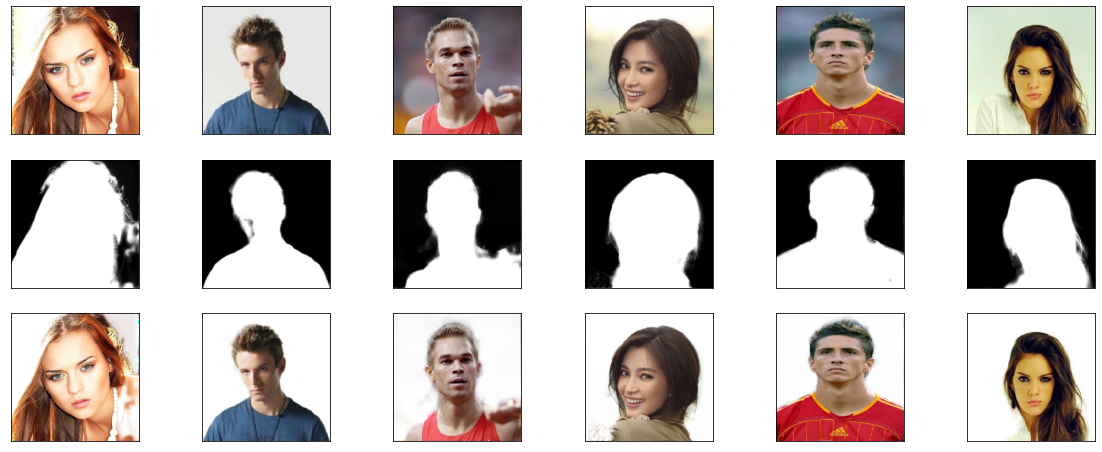

In [102]:
n = 6  # number of samples
img_index = 0

plt.figure(figsize=(20, 8))
for i in range(n):
    
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images_visualization[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # matting
    ax = plt.subplot(3, n, i + n + n+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = test_images_visualization[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3)
    mask = decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel)
    red, green, blue = img.T
    red=red**mask.T
    green=green**mask.T
    blue = blue**mask.T
    matted = np.array((red,green,blue)).T
    plt.imshow(matted)
    
plt.show()

The results look fine, but we might achieve better by applying refinement.  

### 3.3.2 Implementation of Deep Image Matting Model

#### 3.3.2.1 Idea

The SegNet output looks good. However, the the details like flying hairs might be better preserved.  
A solution to this problem is proposed in [Deep Image Matting](https://arxiv.org/pdf/1703.03872.pdf) paper by Ning Xu, Brian Price, Scott Cohen, and Thomas Huang.  

#### 3.3.2.2 Implementation
This network is also an encoder-decoder network, but it refines the output by applying a refinement. Below is an illustration:  

![SegNet](images/deep-image-matting.png)

Illustration: Taken from the [Deep Image Matting](https://arxiv.org/pdf/1703.03872.pdf) paper.  

We will build the deep matting model on top of our previous encoder-decoder model.  

From the paper: 

> During training, we first update the encoder-decoder part without the refinement part. After the encoder-decoder part is converged, we fix its parameters and then update the refinement part.  

Threfore, we need to freeze our converged convolutional encoder decoder model, then do the refinement.  

Freezing all the layers of our initial encoder-decoder model:  

In [29]:
for l in segnet.layers:
    l.trainable = False

Now, we can define add the layers for the refinement:  

In [31]:
input_tensor = segnet.input

input = Lambda(lambda i: i[:, :, :, 0:3])(input_tensor)

x = Concatenate(axis=3)([input, segnet.output])

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='refinement_pred', kernel_initializer='he_normal',
           bias_initializer='zeros')(x)

model_matting = Model(inputs=input_tensor, outputs=x)

Printing Layer names and whether they are trainable or not:  

In [103]:
# for l in model_matting.layers:
#     print(l.name, l.trainable)

#### 3.3.2.3 Understanding the Loss Functions

Three loss are mentioned the the paper: **alpha prediction loss**, **compositional loss**, and **overall loss**:  

**The Alpha Prediction Loss** is the absolute difference between the ground truth alpha values and the predicted alpha values at each pixel. 

$$\mathcal{L}_{\alpha}^{i}=\sqrt{\left(\alpha_{p}^{i}-\alpha_{g}^{i}\right)^{2}+\epsilon^{2}}, \quad \alpha_{p}^{i}, \alpha_{g}^{i} \in[0,1]$$

In [33]:
img_rows, img_cols = img_dim_pixel, img_dim_pixel
epsilon = 1e-6
epsilon_sqr = epsilon ** 2

def alpha_prediction_loss(y_true, y_pred):
    mask = y_true[:, :, :, 1]
    diff = y_pred[:, :, :, 0] - y_true[:, :, :, 0]
    diff = diff * mask
    num_pixels = K.sum(mask)
    return K.sum(K.sqrt(K.square(diff) + epsilon_sqr)) / (num_pixels + epsilon)

**The compositional loss** is the absolute difference between the ground truth RGB colors and the predicted RGB colors composited by the ground truth foreground, the ground truth background and the predicted alpha mattes.  

$$\mathcal{L}_{c}^{i}=\sqrt{\left(c_{p}^{i}-c_{g}^{i}\right)^{2}+\epsilon^{2}}$$

c: the RGB channel  
p: denotes the image composited by the predicted alpha  
g: denotes the image composited by the ground truth alphas  

In [34]:
def compositional_loss(y_true, y_pred):
    mask = y_true[:, :, :, 1]
    mask = K.reshape(mask, (-1, img_rows, img_cols, 1))
    image = y_true[:, :, :, 2:5]
    fg = y_true[:, :, :, 5:8]
    bg = y_true[:, :, :, 8:11]
    c_g = image
    c_p = y_pred * fg + (1.0 - y_pred) * bg
    diff = c_p - c_g
    diff = diff * mask
    num_pixels = K.sum(mask)
    return K.sum(K.sqrt(K.square(diff) + epsilon_sqr)) / (num_pixels + epsilon)

The **overall loss** is the weighted sum of these two losses:    
$$\mathcal{L}_{\text {overall}}=w_{l} \cdot \mathcal{L}_{\alpha}+\left(1-w_{l}\right) \cdot \mathcal{L}_{c}$$

In [35]:
def overall_loss(y_true, y_pred):
    w_l = 0.5
    return w_l * alpha_prediction_loss(y_true, y_pred) + (1 - w_l) * compositional_loss(y_true, y_pred)

Compiling the model: 

Training:

In [36]:
decoder_target = tf.keras.backend.placeholder(dtype='float32', shape=(None, None, None, None))
model_matting.compile(optimizer='adam', loss=overall_loss, target_tensors=[decoder_target])

In [ ]:
model_matting.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=50,
    verbose=1)

In [57]:
model_name = 'model_matting_'+str(img_dim_pixel)+'.h5'
model_matting.save(model_name)

#### 3.3.2.4 Visualizing the results

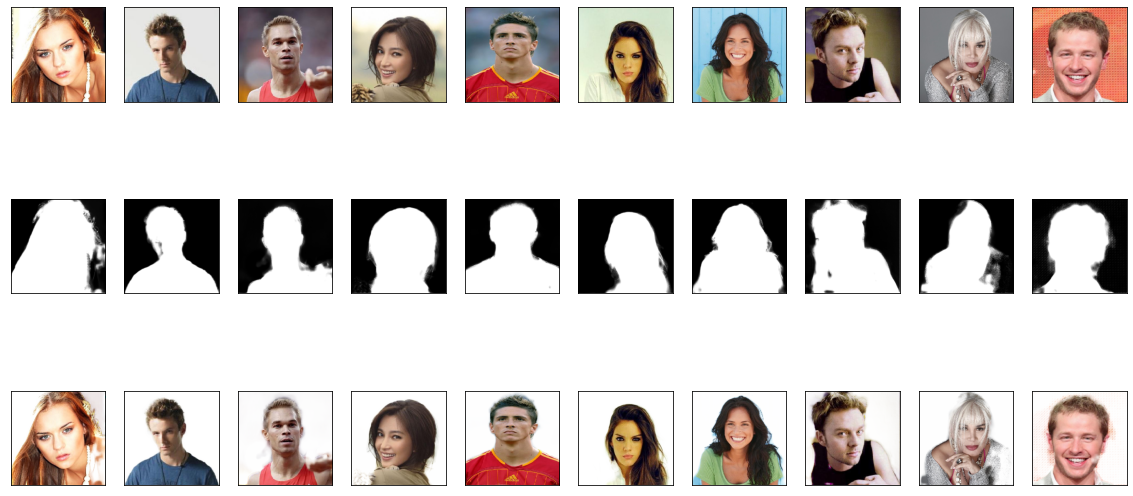

In [75]:
test_images_visualization = next(image_test_generator)
decoded_imgs = model_matting.predict(test_images_visualization, verbose=0)

import matplotlib.pyplot as plt

n = 10  # number of samples
img_index = 0
plt.figure(figsize=(20, 10))
for i in range(n):
    
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images_visualization[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # mask
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # matting
    ax = plt.subplot(3, n, i + n + n+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = test_images_visualization[img_index+i].reshape(img_dim_pixel, img_dim_pixel,3)
    mask = decoded_imgs[img_index+i].reshape(img_dim_pixel, img_dim_pixel)
    red, green, blue = img.T
    red=red**mask.T
    green=green**mask.T
    blue = blue**mask.T
    matted = np.array((red,green,blue)).T
    plt.imshow(matted)
    
plt.show()

Seeing a single example:

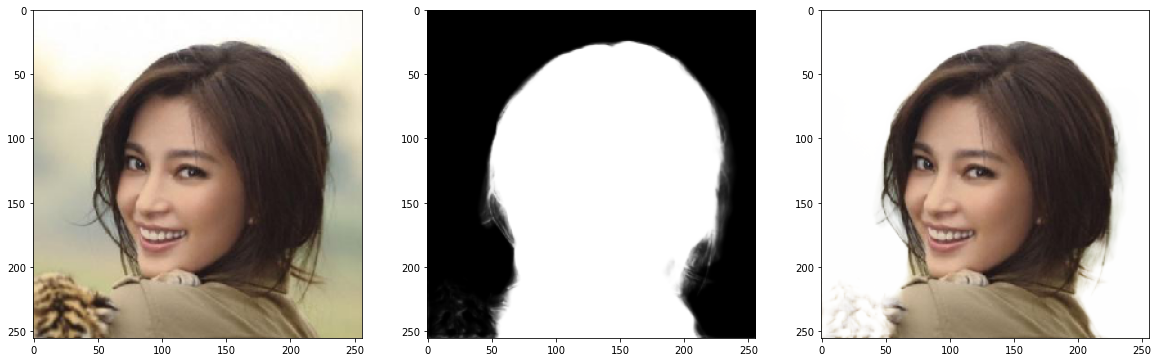

In [89]:
n = 3
img = test_images_visualization[n].reshape(img_dim_pixel, img_dim_pixel,3)
mask = decoded_imgs[n].reshape(img_dim_pixel, img_dim_pixel)
red, green, blue = img.T
red=red**mask.T
green=green**mask.T
blue = blue**mask.T
matted = np.array((red,green,blue)).T

f, axarr = plt.subplots(1,3)
f.set_figheight(20)
f.set_figwidth(20)
axarr[0].imshow(img)
axarr[1].imshow(mask)
axarr[2].imshow(matted)

# 4. Conclusion
This is a simple implementation of the Deep Image Matting. We see how refinement improved the performance by keeping the details like hairs.  
There is still room for development. I would assume that it would bring better results with more training data.  